In [1]:
from IPython.display import Markdown, display
import sys
import copy
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import stdev as sd, mean
from scipy.stats import randint as sp_randint, uniform
import time

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas,\
                    load_preproc_data_adult_5att, load_preproc_data_artificial, \
                    load_preproc_data_adult_continuous, load_preproc_data_german_continuous
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult, get_distortion_german, get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
from common_utils import *

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score
from sklearn import svm, datasets
from sklearn.datasets import load_digits, load_iris, make_hastie_10_2
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

sys.path.append('/home/andrew/python-virtual-environments/hyperband/scikit-hyperband/hyperband')
from miti_search import HyperbandSearchCV

import pickle
filename = 'X_y_data_info_german_step_2'
infile = open(filename,'rb')
transf_data_info = pickle.load(infile)
infile.close()

In [2]:
X_check = transf_data_info['X']
y_check = transf_data_info['y']
w_check = transf_data_info['og_w']
og_pred = transf_data_info['y_pred']
bin_pred = transf_data_info['y_bin_pred']
thresh = transf_data_info['thresh']
test_ind = transf_data_info['test_ind']
sample_dict = transf_data_info['sample_dict']
step = transf_data_info['step']

In [3]:
lmod = LogisticRegression()
lmod.fit(X_check[test_ind:,], y_check[test_ind:], w_check['sample_weight'][test_ind:])
y_train_pred = lmod.predict(X_check[test_ind:,])
y_test_pred = lmod.predict_proba(X_check[:test_ind])[:,0].reshape(-1,1)

y_check = [1 if i < 1.5 else 0 for i in y_check]
y_binary = [1 if i > thresh else 0 for i in y_test_pred]

print(np.array_equal(y_test_pred, og_pred))
print('accu: ', accuracy_score(y_binary, y_check[:test_ind]))

priv, unpriv, p_pos, u_pos, p_tp, u_tp, pred_p_pos, pred_u_pos = 0,0,0,0,0,0,0,0

for i in range(len(X_check[:test_ind][:,1])):
    if X_check[:test_ind][:,0][i] > 0:
        priv +=1
        if y_check[:test_ind][i] == 1:
            p_pos +=1
            if y_binary[i] == 1:
                p_tp +=1
        if y_binary[i] == 1:
            pred_p_pos +=1
    else:
        unpriv +=1
        if y_check[:test_ind][i] == 1:
            u_pos +=1
            if y_binary[i] == 1:
                u_tp +=1
        if y_binary[i] == 1:
            pred_u_pos +=1
    
total = len(y_binary)
print(sum(y_binary))
print(f'total: {total}, priv: {priv}, unpriv: {unpriv}, p_pos: {p_pos}, u_pos: {u_pos}, p_tp: {p_tp}, u_tp: {u_tp}')
print('percent priv:', priv/total)
print('percent posi:', (p_pos+u_pos)/total)
print('percent pred:', (pred_p_pos+pred_u_pos)/total)
print("TPR", p_tp/p_pos, u_tp/u_pos, (p_tp+u_tp)/(p_pos+u_pos))
print('TP-Ratio:', (u_tp/u_pos)/(p_tp/p_pos))
print('disp_imp:', (pred_u_pos/unpriv)/(pred_p_pos/priv))

pos, neg, tps, tns = 0,0,0,0

for i in range(len(y_binary)):
    if y_check[:test_ind][i] == 1:
        pos += 1
        if y_binary[i] == 1:
            tps +=1
    else:
        neg += 1
        if y_binary[i] == 0:
            tns +=1

print(pos, neg, tps, tns)
trrs = tps/pos
tnrs = tns/neg

bal_acc = 0.5*(trrs+tnrs)
print('bal_acc:', bal_acc)

True
accu:  0.62
70
total: 150, priv: 122, unpriv: 28, p_pos: 87, u_pos: 18, p_tp: 52, u_tp: 7
percent priv: 0.8133333333333334
percent posi: 0.7
percent pred: 0.4666666666666667
TPR 0.5977011494252874 0.3888888888888889 0.5619047619047619
TP-Ratio: 0.6506410256410255
disp_imp: 0.5622119815668203
105 45 59 34
bal_acc: 0.6587301587301587


In [4]:
int(index_map['pp']*100//1)

NameError: name 'index_map' is not defined

In [6]:
total_time = []
for i in range(1):
    start_time = time.time()
    index_map = transf_data_info['index_map']
    uniform_weights = {'priv_pos': sp_randint(int(index_map['pp']*100//1), 100),
                       'priv_neg': sp_randint(100, int(index_map['pn']*100//1)),
                       'unpriv_pos': sp_randint(100, int(index_map['up']*100//1)),
                       'unpriv_neg': sp_randint(int(index_map['un']*100//1), 100)}

    param_dist = {}
    model_parameters = {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 7,
                        'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 81}
    train, test = None, None

    model = LogisticRegression()
    model_parameters = {}
    ratio = 1 # [0,1] applies to first metric 0 means met1 is not included 1 means only met 1 is included
    met1 = 'balanced accuracy'
    met2 = 'disparate impact'
    limit1=0.5
    limit2=0.5
    po=1
    ne=0
    att=0

    is_distribution = True
    if is_distribution:
        sample_dict = uniform_weights

    search = HyperbandSearchCV(model, param_dist, 
                               resource_param='max_iter',
                               scoring='balanced_accuracy',
                               n_jobs=5, verbose=0,
                               miti_params=sample_dict,
                               model_params=model_parameters,
                               train=train, test=test, instance_base=w_check,
                               is_distribution=is_distribution, index_map=index_map)

    search.fit(X_check, y_check, thresh, met1, met2, ratio, limit1, limit2, po, ne, att)
    this_time = (time.time() - start_time)
    total_time.append(this_time)
    print(this_time)
# print(f"--- {mean(total_time)} seconds stdev: {sd(total_time)}---")

2.8225595951080322


In [7]:
indexes=[0,1,2,7]
working_dict = search.data_list.copy()
hyper_band_bracket = working_dict[-1]
working_dict[-1].pop('hyperband_bracket')

for i in working_dict:
    for j in range(len(i['param_sample_weight'])):
        unique_weights = []
        for k in indexes:
            unique_weights.append(i['param_sample_weight'][j][k])
        i['param_sample_weight'][j] = unique_weights
    i.pop('params') 
working_dict

[{'mean_fit_time': array([0.00169644, 0.00161586, 0.00149875, 0.00178308, 0.00172524,
         0.00157466, 0.00147796, 0.00152607, 0.00148902, 0.00180988,
         0.00171342, 0.00144701, 0.0015336 , 0.00143375, 0.00185494,
         0.00226264, 0.00190048, 0.0014668 , 0.00159473, 0.00143771,
         0.00199757, 0.00181818, 0.00166264, 0.00160551, 0.00161147,
         0.00165434, 0.00152736, 0.0015295 , 0.0015099 , 0.00187278,
         0.0015183 , 0.00153828, 0.00144792, 0.0020124 , 0.00139613,
         0.00150647, 0.00136456, 0.00206842, 0.00216961, 0.00227413,
         0.00221615, 0.00222111, 0.00177541, 0.00162363, 0.00174804,
         0.00209846, 0.00151963, 0.00148654, 0.00137806, 0.00141039,
         0.00207181, 0.0022891 , 0.00218263, 0.00227985, 0.00207562,
         0.00155082, 0.00148458, 0.00156612, 0.00159106, 0.00211935,
         0.00204229, 0.0016983 , 0.00154991, 0.00172291, 0.00169659,
         0.00138578, 0.00149484, 0.0014143 , 0.00168281, 0.00192351,
         0.001801

In [8]:
df = pd.DataFrame()
for dict_array in working_dict:
    df = pd.concat([df, pd.DataFrame.from_dict(dict_array)], sort=False)
print(df.columns)
df

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'mean_test_acc', 'std_test_acc', 'mean_test_ba', 'std_test_ba',
       'mean_test_pp', 'std_test_pp', 'mean_test_di', 'std_test_di',
       'mean_test_tpr', 'std_test_tpr', 'mean_test_tnr', 'std_test_tnr',
       'mean_test_posrat', 'std_test_posrat', 'mean_test_tradeoff_met',
       'std_test_tradeoff_met', 'param_sample_weight', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_acc,std_test_acc,mean_test_ba,std_test_ba,mean_test_pp,std_test_pp,...,std_test_tradeoff_met,param_sample_weight,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001696,0.000257,0.000651,0.000118,0.555294,0.035993,0.626783,0.052789,0.398824,0.052797,...,0.052789,"[1, 1, 1, 1]",0.616626,0.693487,0.681733,0.562500,0.579568,0.626783,0.052789,80
1,0.001616,0.000264,0.000698,0.000132,0.551765,0.036527,0.716026,0.120631,0.414118,0.079844,...,0.120631,"[1.0824977538185085, 0.9675318246110325, 1.159...",0.628579,0.929944,0.647400,0.767630,0.606578,0.716026,0.120631,1
2,0.001499,0.000129,0.000664,0.000184,0.547059,0.040413,0.671139,0.099744,0.407059,0.080431,...,0.099744,"[1.07, 0.96, 1.14, 0.96]",0.624342,0.868130,0.647400,0.617647,0.598175,0.671139,0.099744,6
3,0.001783,0.000268,0.000600,0.000044,0.554118,0.033566,0.667786,0.104107,0.421176,0.072770,...,0.104107,"[1.03, 0.96, 1.04, 0.81]",0.624342,0.872368,0.647400,0.589357,0.605464,0.667786,0.104107,9
4,0.001725,0.000416,0.000604,0.000073,0.557647,0.033151,0.662413,0.088180,0.412941,0.069740,...,0.088180,"[1.02, 0.99, 1.01, 0.81]",0.624342,0.820151,0.694444,0.589357,0.583770,0.662413,0.088180,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,0.002560,0.000103,0.000552,0.000018,0.598824,0.027691,0.781470,0.094996,0.477647,0.064588,...,0.094996,"[1.04, 0.99, 1.1, 0.76]",0.775582,0.929944,0.773968,0.797181,0.630674,0.781470,0.094996,36
183,0.003511,0.001094,0.000612,0.000074,0.598824,0.027691,0.768436,0.083714,0.468235,0.058422,...,0.083714,"[1.07, 0.99, 1.09, 0.84]",0.775582,0.868130,0.731011,0.836783,0.630674,0.768436,0.083714,88
184,0.004390,0.001099,0.000928,0.000433,0.601176,0.029152,0.783165,0.094952,0.480000,0.063638,...,0.094952,"[1.0, 0.97, 1.1, 0.8]",0.784057,0.929944,0.773968,0.797181,0.630674,0.783165,0.094952,10
185,0.004177,0.000601,0.000991,0.000147,0.598824,0.027691,0.768436,0.083714,0.468235,0.058422,...,0.083714,"[1.05, 0.96, 1.04, 0.81]",0.775582,0.868130,0.731011,0.836783,0.630674,0.768436,0.083714,88


In [10]:
# og_weight, og_ba, og_di = [], [], []
# rw_weight, rw_ba, rw_di = [], [], []

# for i in range(len(working_dict)):
#     og_weight.append(working_dict[i]['param_sample_weight'][0])
#     og_ba.append(working_dict[i]['mean_test_ba'][0])
#     og_di.append(working_dict[i]['mean_test_di'][0])
#     rw_weight.append(working_dict[i]['param_sample_weight'][1])
#     rw_ba.append(working_dict[i]['mean_test_ba'][1])
#     rw_di.append(working_dict[i]['mean_test_di'][1])
    
# print(og_di)
# print(rw_di)

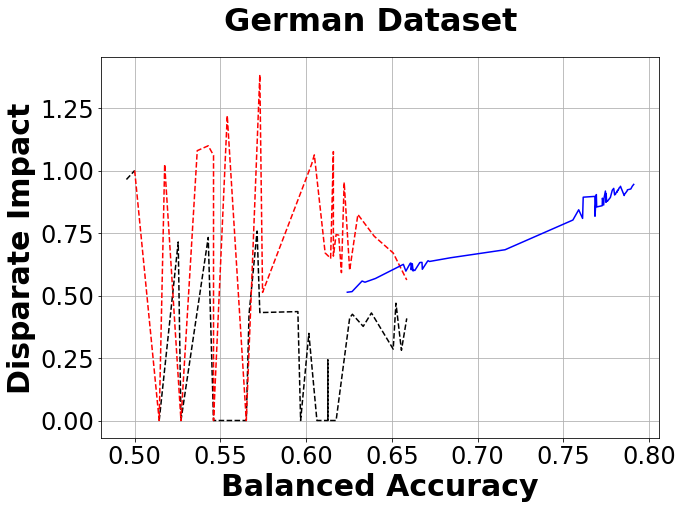

In [11]:
Data_Name = 'German_Random'
x_label = 'Balanced Accuracy'
y_label = 'Disparate Impact'
x_axis, y_axis = 'mean_test_ba', 'mean_test_di'
df_sorted = df.sort_values(by=x_axis)

orig_array = transf_data_info['orig_array']
trans_array = transf_data_info['trans_array']
orig_sort = orig_array[orig_array[:,2].argsort()]
trans_sort = trans_array[trans_array[:,2].argsort()]

mx = df_sorted

fig, ax1 = plt.subplots(figsize=(10,7))
fig.suptitle('German Dataset', fontsize='32', fontweight='bold')
ax1.set_xlabel(x_axis, fontsize=30, fontweight='bold')
ax1.set_xlabel(x_label, color='k', fontsize=30, fontweight='bold')
ax1.set_ylabel(y_label, color='k', fontsize=30, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=24)
ax1.yaxis.set_tick_params(labelsize=24)
ax1.grid(True)

# ax1.plot(orig_sort[:,3], orig_sort[:,8], '--', color='k', label='Original Data')
# ax1.plot(trans_sort[:,3], trans_sort[:,8], '--', color='r', label='Re-weight Data')
ax1.plot(orig_sort[:,2], orig_sort[:,4], '--', color='k', label='Original Data')
ax1.plot(trans_sort[:,2], trans_sort[:,4], '--', color='r', label='Re-weight Data')

# ax1.plot(mx[x_axis], mx['mean_test_acc'], color='k', label='Accuracy')
# ax1.plot(mx[x_axis], mx['mean_test_ba'], '--', color='k', label='Bal. Accuracy')
# ax1.plot(mx[x_axis], mx['mean_test_pp'], color='b', label='Percent Pos.')
ax1.plot(mx[x_axis], mx['mean_test_di'], color='b', label='Disparate Imp.')
# ax1.plot(mx[x_axis], mx['mean_test_tpr'], color='b', label='TPR')
# ax1.plot(mx[x_axis], mx['mean_test_posrat'], '--', color='b', label='TPR-ratio')
# ax1.plot(mx[x_axis], mx['mean_test_tradeoff_met'], color='y', label='Tradeoff Metric')
# ax1.plot(mx[x_axis], mx['mean_test_tnr'], color='r', label='TNR')

# start, end = ax1.get_ylim()
# ax1.yaxis.set_ticks(np.arange(start, end, 0.05))

# ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
now = datetime.now()
file_loc = '/home/andrew/Desktop/Test_Files/HyperParamTune/PLOTS/'
file_name = f'{Data_Name}_{x_axis}_{y_axis}_og_miti_HO_{ratio}_{now}.png'
destination = file_loc + file_name
# plt.savefig(destination)

# df.to_csv(f'/home/andrew/Desktop/Test_Files/HyperParamTune/HB_Mitigation_Outputs/German_output:tradeoff={ratio}_step{step}_thresh_{thresh}.csv', index=False)
# df_sorted.to_csv(f'/home/andrew/Desktop/Test_Files/HyperParamTune/HB_Mitigation_Outputs/German_out_sorted:trade_off={ratio}_step{step}_thresh_{thresh}.csv', index=False)

In [12]:
#Example of HyperBand with Rand-Forest on Digits dataset
total_time = []
for i in range(1):
    start_time = time.time()

    index_map = transf_data_info['index_map']
    uniform_weights = {'priv_pos': sp_randint(int(index_map['pp']*100//1), 100),
                       'priv_neg': sp_randint(100, int(index_map['pn']*100//1)),
                       'unpriv_pos': sp_randint(100, int(index_map['up']*100//1)),
                       'unpriv_neg': sp_randint(int(index_map['un']*100//1), 100)}

    param_dist = {}
    model_parameters = {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 7,
                        'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 81}
    train, test = None, None

    model = LogisticRegression()
    model_parameters = {}
    ratio = 0.5 # [0,1] applies to first metric 0 means met1 is not included 1 means only met 1 is included
    met1 = 'balanced accuracy'
    met2 = 'disparate impact'
    limit1=0.5
    limit2=0.5
    po=1
    ne=0
    att=1

    is_distribution = True
    if is_distribution:
        sample_dict = uniform_weights

    r_search = RandomizedSearchCV(model, param_dist, n_iter=121,
                               scoring='balanced_accuracy',
                               n_jobs=5, verbose=0,
                               miti_params=sample_dict,
                               model_params=model_parameters,
                               train=train, test=test, instance_base=w_check,
                               is_distribution=is_distribution, index_map=index_map)

    r_search.fit(X_check, y_check, thresh, met1, met2, ratio, limit1, limit2, po=po, ne=ne, att=att)
    this_time = (time.time() - start_time)
    total_time.append(this_time)
    print(this_time)
# print(f"--- {mean(total_time)} seconds stdev: {sd(total_time)}---")

1.293370246887207


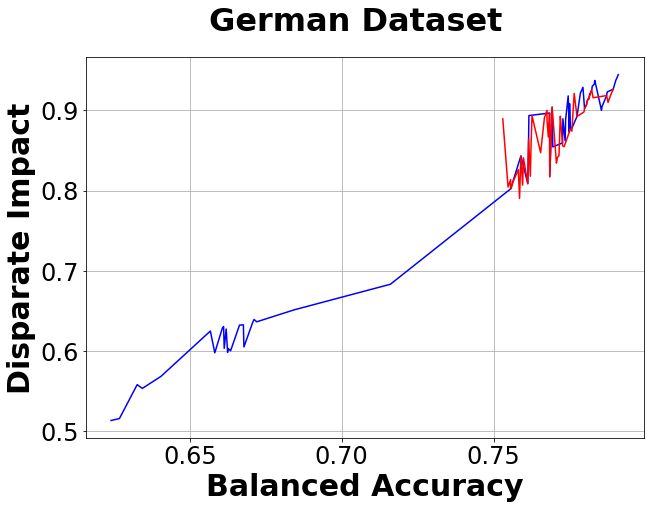

In [13]:
Data_Name = 'German_Grid'
x_label = 'Balanced Accuracy'
y_label = 'Disparate Impact'
x_axis, y_axis = 'mean_test_ba', 'mean_test_di'

df_rand = pd.DataFrame()
for dict_array in r_search.data_list:
    df_rand = pd.concat([df_rand, pd.DataFrame.from_dict(dict_array)], sort=False)
rand_mx = df_rand.sort_values(by=x_axis)

fig, ax1 = plt.subplots(figsize=(10,7))
fig.suptitle('German Dataset', fontsize='32', fontweight='bold')
ax1.set_xlabel(x_axis, fontsize=30, fontweight='bold')
ax1.set_xlabel(x_label, color='k', fontsize=30, fontweight='bold')
ax1.set_ylabel(y_label, color='k', fontsize=30, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=24)
ax1.yaxis.set_tick_params(labelsize=24)
ax1.grid(True)

ax1.plot(mx[x_axis], mx['mean_test_di'], color='b', label='Disparate Imp.')
ax1.plot(rand_mx[x_axis], rand_mx['mean_test_di'], color='r', label='Disparate Imp.')

now = datetime.now()
file_loc = '/home/andrew/Desktop/Test_Files/HyperParamTune/PLOTS/'
file_name = f'{Data_Name}_{x_axis}_{y_axis}_og_miti_HO_{ratio}_{now}.png'
destination = file_loc + file_name
# plt.savefig(destination)

In [14]:
import pickle
filename = 'Grid_german_step_2'
infile = open(filename,'rb')
grid_data_info = pickle.load(infile)
infile.close()

grid_dict = grid_data_info['sample_dict']
grid_dict

{'pp': [0.95, 0.97, 0.99, 1.01],
 'pn': [1.0, 1.02, 1.04, 1.06, 1.08],
 'up': [1.0, 1.02, 1.04, 1.06, 1.08, 1.1, 1.12, 1.14, 1.16],
 'un': [0.74,
  0.76,
  0.78,
  0.8,
  0.82,
  0.84,
  0.86,
  0.88,
  0.9,
  0.92,
  0.94,
  0.96,
  0.98,
  1.0]}

In [16]:
#Example of HyperBand with Rand-Forest on Digits dataset
total_time = []
for i in range(10):
    start_time = time.time()

    param_dist = {}
    model_parameters = {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 7,
                        'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 81}
    train, test = None, None

    model = LogisticRegression()
    model_parameters = {}
    ratio = 0.5 # [0,1] applies to first metric 0 means met1 is not included 1 means only met 1 is included
    met1 = 'balanced accuracy'
    met2 = 'disparate impact'
    limit1=0.5
    limit2=0.5
    po=1
    ne=0
    att=1

    is_distribution = True

    g_search = GridSearchCV(model, param_dist, scoring='balanced_accuracy',
                               n_jobs=5, verbose=0,
                               miti_params=grid_dict,
                               model_params=model_parameters,
                               train=train, test=test, instance_base=w_check,
                               is_distribution=is_distribution, index_map=index_map)

    g_search.fit(X_check, y_check, thresh, met1, met2, ratio, limit1, limit2, po=po, ne=ne, att=att)
    this_time = (time.time() - start_time)
    total_time.append(this_time)
    print(this_time)
print(f"--- {mean(total_time)} seconds stdev: {sd(total_time)}---")

Num - configs before:  2520
30
18.415088653564453
Num - configs before:  2520
30
18.63797616958618
Num - configs before:  2520
30
20.429030179977417
Num - configs before:  2520
30
20.05283212661743
Num - configs before:  2520
30
18.43438696861267
Num - configs before:  2520
30
19.307219743728638
Num - configs before:  2520
30
19.043497323989868
Num - configs before:  2520
30
18.591413974761963
Num - configs before:  2520
30
18.844209671020508
Num - configs before:  2520
30
19.16338586807251
--- 19.091904067993163 seconds stdev: 0.6809636880414391---


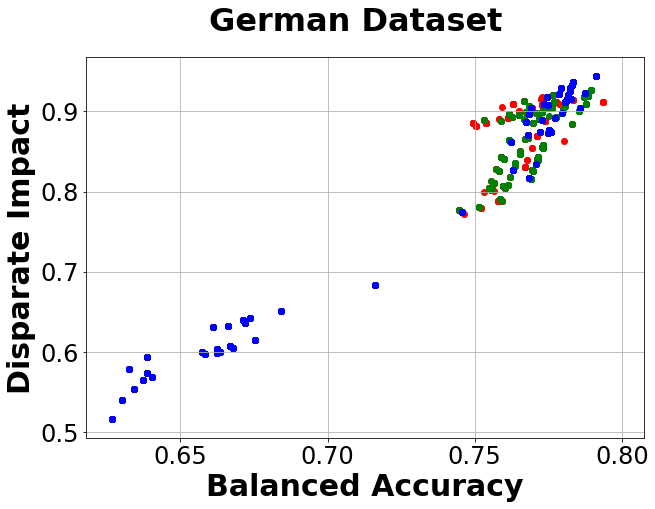

In [27]:
Data_Name = 'German_Grid_Rand'
x_label = 'Balanced Accuracy'
y_label = 'Disparate Impact'
x_axis, y_axis = 'mean_test_ba', 'mean_test_di'

df_grid = pd.DataFrame()
for dict_array in g_search.data_list:
    df_grid = pd.concat([df_grid, pd.DataFrame.from_dict(dict_array)], sort=False)
grid_mx = df_grid.sort_values(by=x_axis)

fig, ax1 = plt.subplots(figsize=(10,7))
fig.suptitle('German Dataset', fontsize='32', fontweight='bold')
ax1.set_xlabel(x_label, color='k', fontsize=30, fontweight='bold')
ax1.set_ylabel(y_label, color='k', fontsize=30, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=24)
ax1.yaxis.set_tick_params(labelsize=24)
ax1.grid(True)

ax1.scatter(grid_mx[x_axis], grid_mx['mean_test_di'], color='r', label='Disparate Imp.')
ax1.scatter(rand_mx[x_axis], rand_mx['mean_test_di'], color='g', label='Disparate Imp.')
ax1.scatter(mx[x_axis], mx['mean_test_di'], color='b', label='Disparate Imp.')

now = datetime.now()
file_loc = '/home/andrew/Desktop/Test_Files/HyperParamTune/PLOTS/'
file_name = f'{Data_Name}_{x_axis}_{y_axis}_time_complexity.png'
destination = file_loc + file_name
plt.savefig(destination)